In [1]:
import pandas as pd
import numpy as np
import psycopg2
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
from scipy.optimize import curve_fit

### Determining the financially optimal rotation age

In [4]:
conn = psycopg2.connect("dbname='Rotations' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT econsummary.*, cases.mgmtid, CAST (cases.standid AS INT) AS siteindex
FROM econsummary, cases
WHERE econsummary.caseid = cases.caseid AND cases.mgmtid = 'SHRT';
'''
short = pd.read_sql(SQL, conn)

# close the database connection
conn.close()

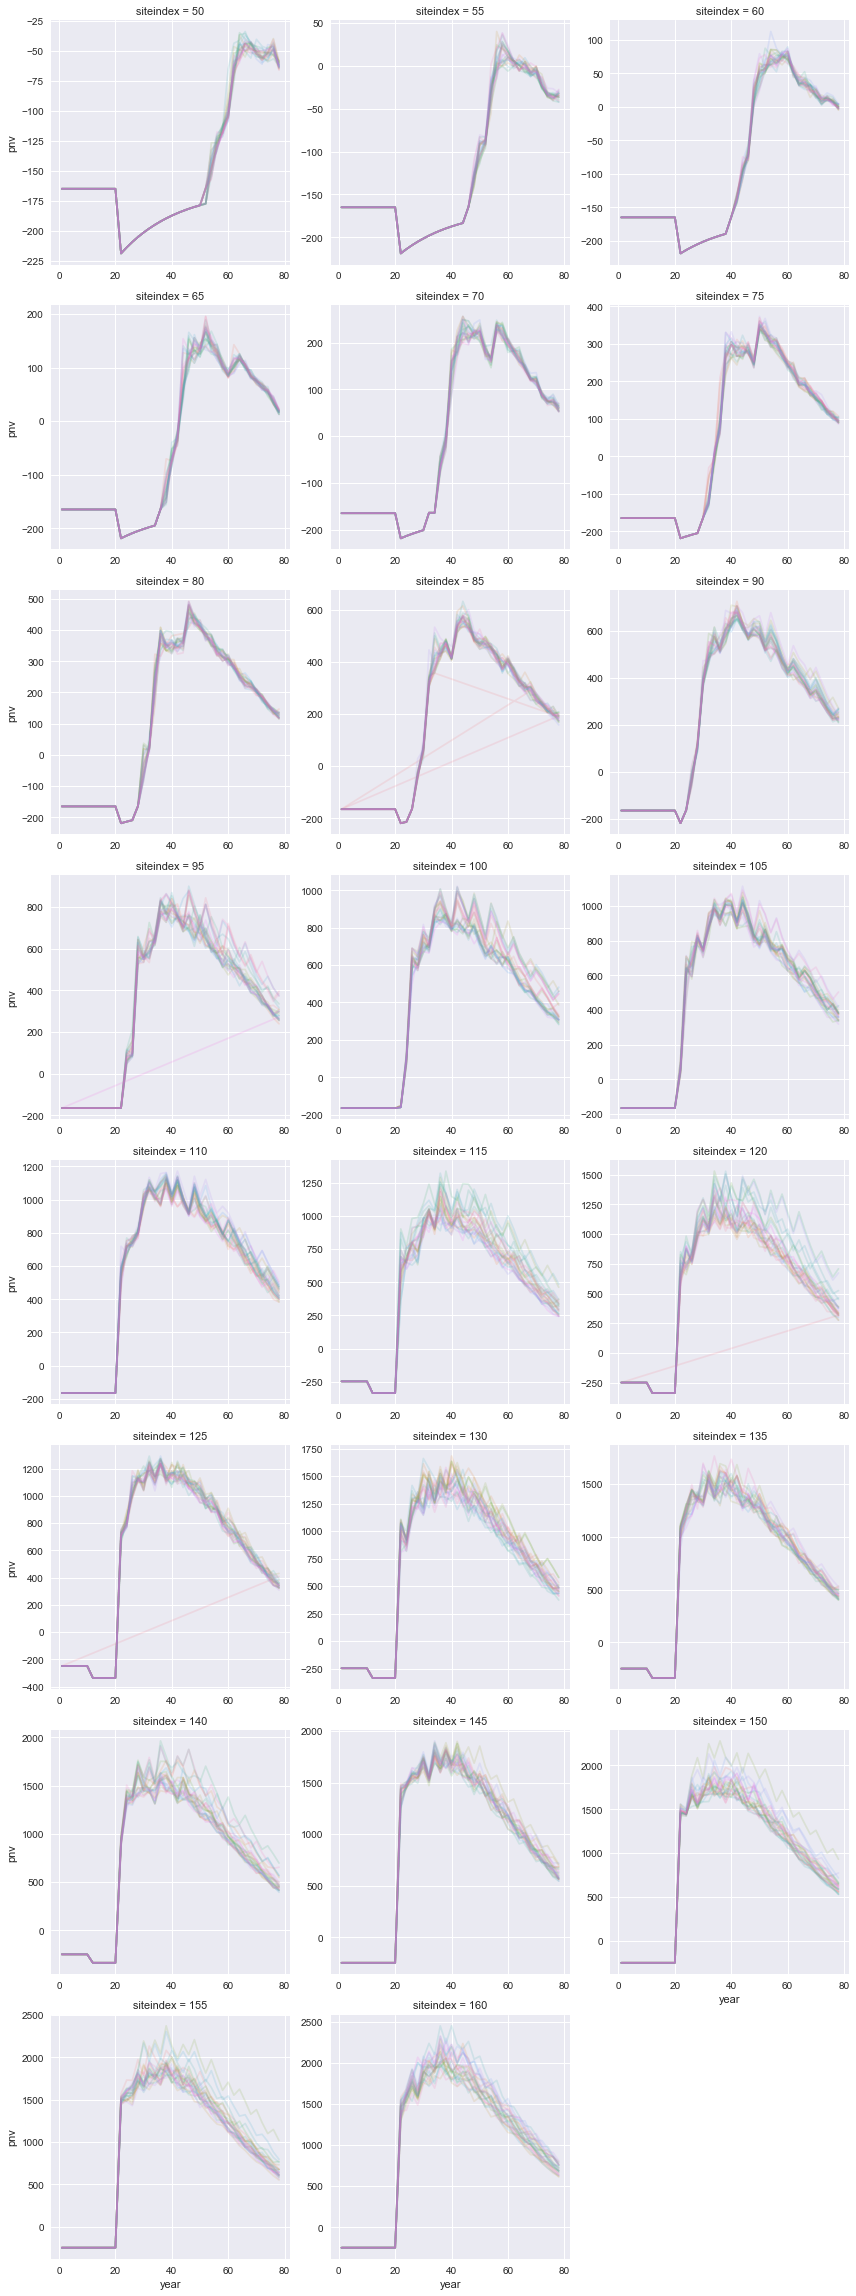

In [5]:
g = sns.FacetGrid(data=short, col='siteindex', hue='caseid', col_wrap=3, size=4, sharey=False, sharex=False)
g = g.map(plt.plot, 'year', 'pnv', alpha=0.15)

In [6]:
def exponential(x, A, B, C):
    return A*(B**x) + C

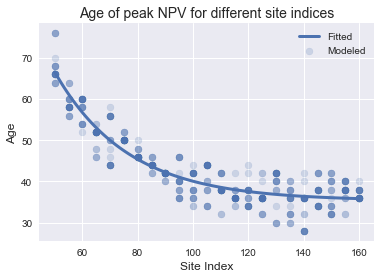

In [7]:
maxes = short[['year', 'siteindex']].iloc[short.groupby(['caseid', 'siteindex'])['pnv'].idxmax()]
stats = maxes.groupby('siteindex').agg(['median', 'mean', 'std'])
plt.scatter(x=maxes.siteindex, y=maxes.year, alpha=0.2, label='Modeled')

# fit an exponential curve to observed NPV max years
popt, pcov = curve_fit(exponential, maxes.siteindex, maxes.year)
xs = np.linspace(50, 160, 100)
plt.plot(xs, exponential(xs, popt[0], popt[1], popt[2]), lw=3, label='Fitted')

plt.title('Age of peak NPV for different site indices', fontsize=14)
plt.xlabel("Site Index", fontsize=12)
plt.ylabel("Age", fontsize=12)
plt.legend();

In [8]:
for var, coef in zip(['A', 'B', 'C'], popt):
    print(var, '=', coef) # coefficients for Exponential Equation

A = 207.552857628
B = 0.962854595697
C = 35.3466057243


### Determining the biologically optimal rotation age

In [9]:
conn = psycopg2.connect("dbname='Rotations' user='postgres' host='localhost'") # password in pgpass file
SQL = '''
SELECT summary.*, cases.mgmtid, CAST (cases.standid AS INT) AS siteindex
FROM summary, cases
WHERE summary.caseid = cases.caseid AND cases.mgmtid = 'LONG';
'''
# read the query into a pandas dataframe
long = pd.read_sql(SQL, conn)
conn.close()

In [10]:
long.columns

Index(['caseid', 'standid', 'year', 'age', 'tpa', 'ba', 'sdi', 'ccf', 'topht',
       'qmd', 'tcuft', 'mcuft', 'bdft', 'rtpa', 'rtcuft', 'rmcuft', 'rbdft',
       'atba', 'atsdi', 'atccf', 'attopht', 'atqmd', 'prdlen', 'acc', 'mort',
       'mai', 'fortyp', 'sizecls', 'stkcls', 'mgmtid', 'siteindex'],
      dtype='object')

In [11]:
long = long.sort_values(['caseid','year']).set_index(['caseid', 'year'])
long['atbdft'] = long.bdft - long.rbdft
# calculate the cumulative boardfoot volume of harvests for each simulation
long['cum_rbdft'] = long.groupby(level=0, as_index=False)['rbdft'].cumsum()
# calculate the total standing plus removed volume
long['std_plus_rem'] = long.atbdft + long.cum_rbdft
long = long.reset_index()
# divide the total standing and removed volume by the year to get mean annual increment
long['tot_mai'] = long.std_plus_rem / long.year

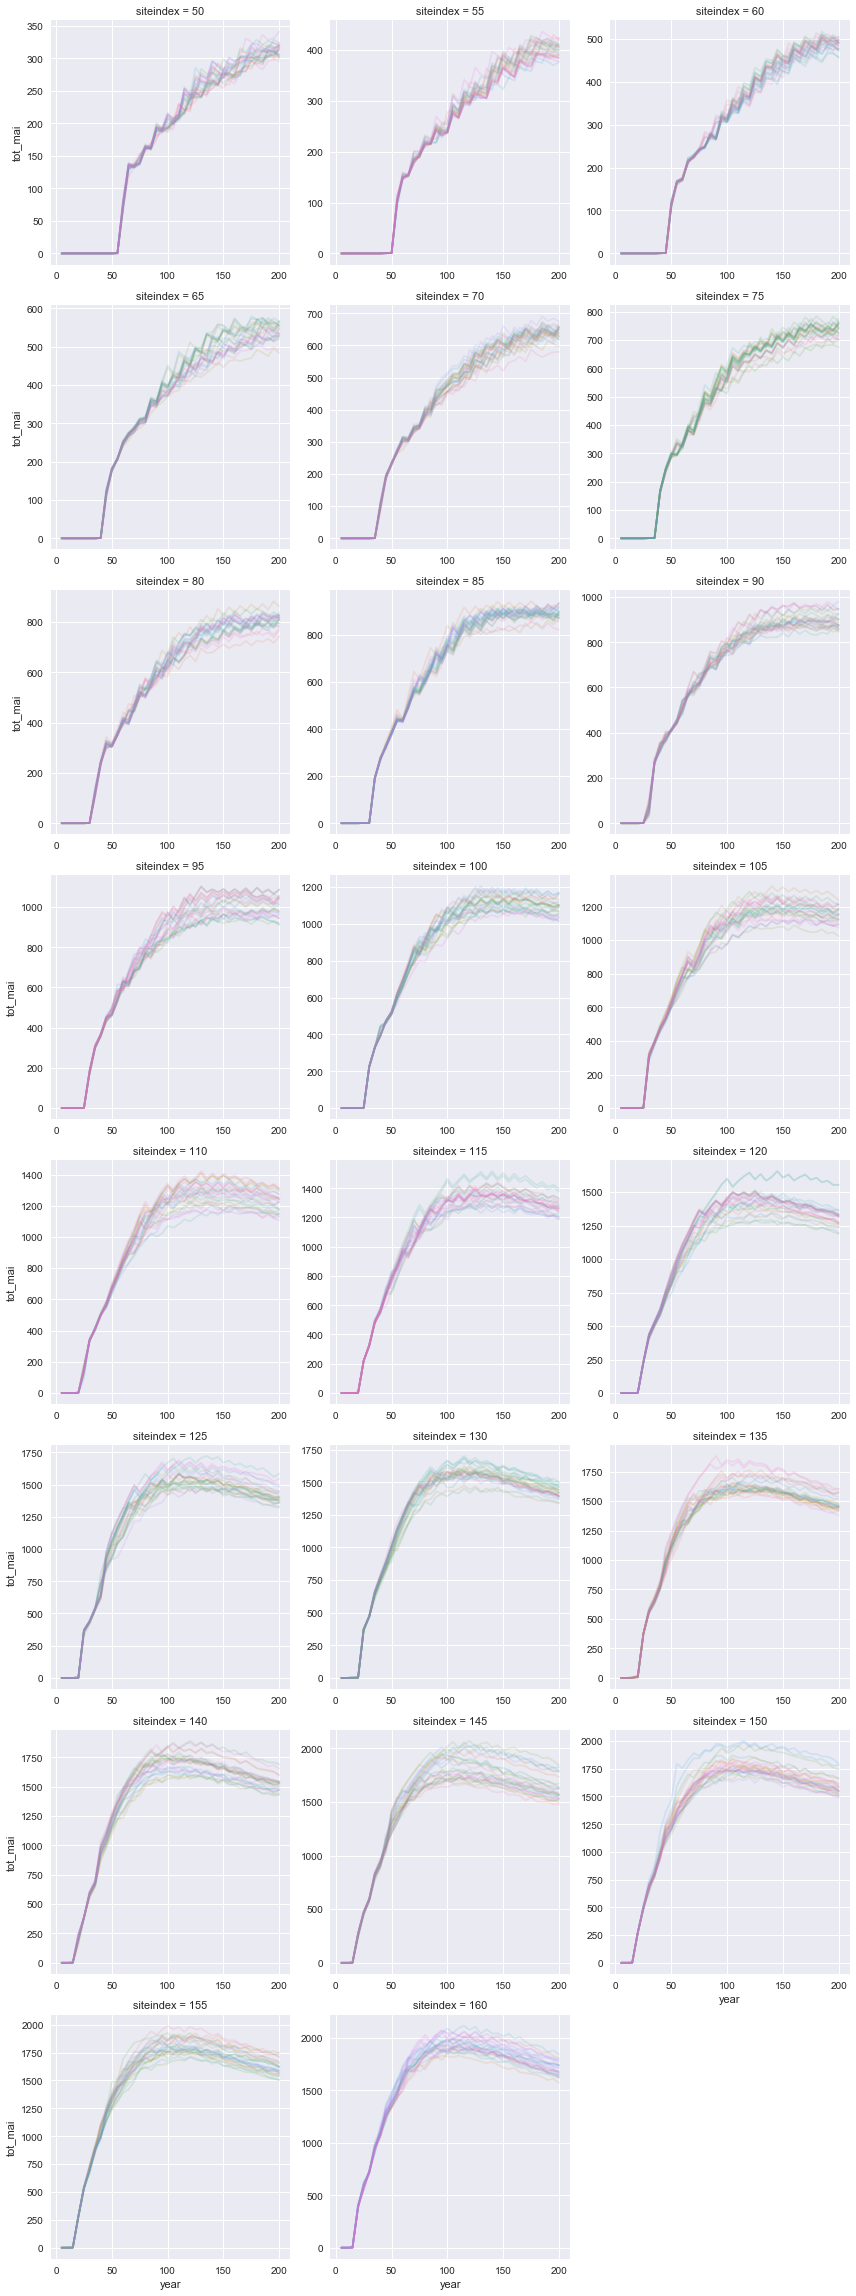

In [12]:
g = sns.FacetGrid(data=long, col='siteindex', hue='caseid', col_wrap=3, size=4, sharey=False, sharex=False)
g = g.map(plt.plot, 'year', 'tot_mai', alpha=0.15)

In [13]:
def richards(x, A, K, B, v, Q, M):
    return A + (K-A)/((1+Q*np.exp(-B*(x-M)))**(1/v))

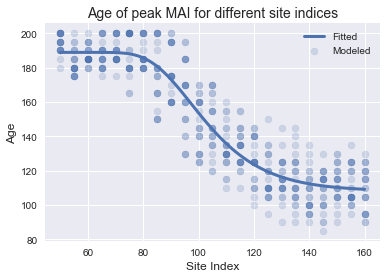

In [14]:
maxes = long[['year', 'siteindex']].iloc[long.groupby(['caseid', 'siteindex'])['tot_mai'].idxmax()]
avg = maxes.groupby('siteindex').mean()
stats = maxes.groupby('siteindex').agg(['median', 'mean', 'std'])
plt.scatter(x=maxes.siteindex, y=maxes.year, alpha=0.2, label="Modeled")

# fit a richards curve to observed MAI max years
popt, pcov = curve_fit(richards, maxes.siteindex, maxes.year, p0=[200, 80, 1,1,1,100], 
                       bounds=([165, 50, -np.inf, 0, -np.inf, -np.inf], #lower bounds
                               [205, 150, np.inf, np.inf, np.inf, np.inf])) # upper bounds

xs = np.linspace(50, 160, 100)
plt.plot(xs, richards(xs, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5]), 
         label="Fitted", lw=3)


plt.title('Age of peak MAI for different site indices', fontsize=14)
plt.xlabel("Site Index", fontsize=12)
plt.ylabel("Age", fontsize=12)
plt.legend();

In [15]:
for var, coef in zip(['A', 'K', 'B', 'v', 'Q', 'M'], popt):
    print(var, '=', coef) # coefficients for Richards Equation

A = 188.883148119
K = 108.08518249
B = 0.0679037885528
v = 0.000138688483893
Q = 0.000153650358859
M = 95.7265439877
